# Tutorial 2. How to create a neural network in PyTorch

In this tutorial we will show how to use an unknown dataset, how to prepare it and other things...

## Preperations
Before we start get sure that PyTorch, Torchvision, and Torchaudio. We recommend to follow the installation steps from the official website: https://pytorch.org/get-started/locally/
Additional li

In [45]:
import torch

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print('Device is ',device)

Device is  cuda


## Importing dataset

We will use the UTK Face dataset

In [104]:
import os
import pandas as pd

def make_annotation_file(path_train, path_test, path_val, labels):
    ## function to iterate through the path and create a annotation csv
    list_train = []
    list_test = []
    list_val = []
    for idx, label in enumerate(labels):        
        for file in os.listdir(path_train+label):
            list_train.append((label+'/'+file, idx))
            
        for file in os.listdir(path_test+label):
            list_test.append((label+'/'+file, idx))

        for file in os.listdir(path_val+label):
            list_val.append((label+'/'+file, idx))
    
    ## create two csv-files for the annotations
    csv_train = pd.DataFrame(list_train, columns = ['',''])
    csv_test = pd.DataFrame(list_test, columns=['',''])
    csv_val = pd.DataFrame(list_val, columns=['',''])

    csv_train.to_csv(path_train+'annot_train.csv', sep=',', index=False)
    csv_test.to_csv(path_test+'annot_test.csv', sep=',', index=False)
    csv_val.to_csv(path_val+'annot_val.csv', sep=',', index=False)

train_data_path = '../Dataset/UTKFace_aligned_paper_split_classification_4classes/train/classes/'
test_data_path = '../Dataset/UTKFace_aligned_paper_split_classification_4classes/test/classes/'
val_data_path = '../Dataset/UTKFace_aligned_paper_split_classification_4classes/val/classes/'
classes = ['0-17','18-40','41-60','61-200']

make_annotation_file(train_data_path, test_data_path, val_data_path, classes)

In [105]:
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [211]:
from torchvision.transforms import v2

transform_augm = transforms.Compose(
[    v2.ToImage(),
     v2.RandomCrop(size=200),
     v2.RandomHorizontalFlip(p=0.5),
     v2.RandomRotation(degrees = 20),
     v2.Resize(size=(281,281)),
     v2.ToDtype(torch.float32, scale=True),
     v2.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229,0.224,0.225]) , ])

transform_norm = transforms.Compose(
[    v2.ToImage(),
     v2.ToDtype(torch.float32, scale=True),
     v2.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229,0.224,0.225]) , ])

batch_size=16

training_data = CustomImageDataset(train_data_path+'annot_train.csv',train_data_path, transform=transform_augm)
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = CustomImageDataset(test_data_path+'annot_test.csv',test_data_path, transform=transform_norm)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

### Plot some sample images

We use the Matplotlib library to show the first four samples from the MNIST training.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.1190476].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.671852].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Classes are: 
18-40 0-17  18-40 18-40 41-60 18-40 18-40 61-200 61-200 41-60 0-17  18-40 18-40 18-40 41-60 18-40


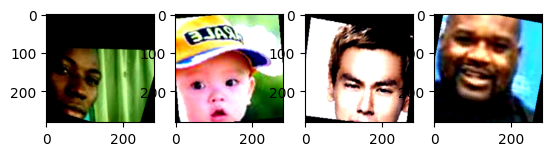

In [212]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(imges):
    plt.figure()
    for i in range(4):
        img = imges[i]
        img = img / 2 + 0.5 #unnormalize
        npimg = img.numpy()
        plt.subplot(1,4,i+1)
        plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(images)

print('Classes are: ')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Create the deep neural network


In [213]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## define the network structure with the layers
        self.conv1 = nn.Conv2d(3,16,5) # in_channels, out_channels, kernel_size 
        self.pool  = nn.MaxPool2d(2,2) # kernel_size, stride
        self.dropout = nn.Dropout(0.2) # dropout factor
        self.conv2 = nn.Conv2d(16,16,5) # in_channels,out_channels, kernel_size
        self.conv3 = nn.Conv2d(16,16,5) # in_channels,out_channels, kernel_size
        self.fc1   = nn.Linear(16*31*31, 120) # in_channels, out_channels
        self.fc2   = nn.Linear(120,84) # in_channels, out_channels
        self.fc3   = nn.Linear(84,4) # in_channels, out_channels

        
    def forward(self, x):
        ## define the functionality of each layer/between the layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x,1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



#### Creating the network
Now we can simple create a new network object and assign in to the device, identified above

In [214]:
net = Net().to(device)

### Set up loss and optimizer
We use the `CrossEntropyLoss`as loss-function between the network output and the labels and using the simple
Stochastic-Gradient-Desced (SGD) optimizer.
Please note, that the `net.parameters()` as parameter into the optimizer defines, which parameters (the parameters from our network) should be tuned during the training.

In [215]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.001)

## Training the network
To train the network, we need a double for loop.
The inner loop used the trainloader object defined above to iterate over the batches of the training set. 

For each batch, we get the input data (the images) and the corresponding labels and assign them to the identified device du to performance reasons.
    
As we calculate the gradients of the weights for each batch independly, we set the gradients to zero:
    
`optimizer.zero_grad()`
    
Then we calculate the output of the network, depending of the inputs, calculating the loss and then propagating the error along the backward path automatically.
    
`outputs = net(inputs)`
    
`loss = criterion(outputs, labels)`
    
`loss.backward()`
    
We apply the gradients via the optimzer:
    
`optimizer.step()`
    
And printing out the loss from the current batch at the end.

All this is repeated for 2 epochs (the outer loop).


In [216]:
from tqdm.notebook import trange, tqdm

for epoch in trange(15):
    running_loss = 0.0
    pbar = tqdm(total = int(14464/batch_size))
    for i, data in enumerate(trainloader, 0):
        # get the input data and labels
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimze
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print statistics
        running_loss += loss.item()
        pbar.update(1)
    print(f'[{epoch +1}, {i + 1:5d}] loss: {running_loss / i:.3f}')
    running_loss = 0.0    
    pbar.close()
    
print('Finished Training')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/904 [00:00<?, ?it/s]

[1,   904] loss: 1.135


  0%|          | 0/904 [00:00<?, ?it/s]

[2,   904] loss: 1.089


  0%|          | 0/904 [00:00<?, ?it/s]

[3,   904] loss: 1.073


  0%|          | 0/904 [00:00<?, ?it/s]

[4,   904] loss: 1.058


  0%|          | 0/904 [00:00<?, ?it/s]

[5,   904] loss: 1.042


  0%|          | 0/904 [00:00<?, ?it/s]

[6,   904] loss: 1.028


  0%|          | 0/904 [00:00<?, ?it/s]

[7,   904] loss: 1.014


  0%|          | 0/904 [00:00<?, ?it/s]

[8,   904] loss: 0.992


  0%|          | 0/904 [00:00<?, ?it/s]

[9,   904] loss: 0.975


  0%|          | 0/904 [00:00<?, ?it/s]

[10,   904] loss: 0.957


  0%|          | 0/904 [00:00<?, ?it/s]

[11,   904] loss: 0.947


  0%|          | 0/904 [00:00<?, ?it/s]

[12,   904] loss: 0.931


  0%|          | 0/904 [00:00<?, ?it/s]

[13,   904] loss: 0.910


  0%|          | 0/904 [00:00<?, ?it/s]

[14,   904] loss: 0.889


  0%|          | 0/904 [00:00<?, ?it/s]

[15,   904] loss: 0.874
Finished Training


After training, we save the parameters of the trained network.

In [217]:
path = './faces_net.pth'
torch.save(net.state_dict(), path)

## Test the network performance
We use the testloader object to see, how well the network will recognice the numbers in the test set.

In [218]:
val_data = CustomImageDataset(val_data_path+'annot_val.csv',val_data_path, transform=transform_norm)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)

dataiter = iter(testloader)
images, labels = next(dataiter)

We create a new network object and load the parameters from the trained network

In [219]:
net = Net()
net.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

We test the furst four images to see, how well they work

In [220]:
output = net(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


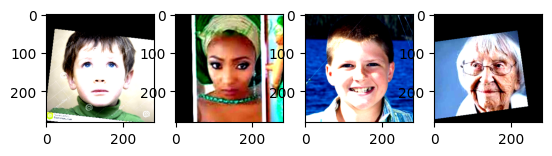

In [221]:
imshow(images)

In [222]:
_, predicted = torch.max(output, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  0-17  18-40 61-200 61-200


As this looks very promising, we write a loop to get the data from the testload batchwise and presenting the to the network.

To avoid, that the network trains further on the test set and to reduce the computational costs, we deactivate the calculation of gradients with `torch.no_grad()`

In [223]:
correct = 0
total   = 0

# use no_grad as we did not want to train further
with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print(f'Accuracy of the network on the test set: {100*correct // total}%')

Accuracy of the network on the test set: 58%


## Conclusion

So in this tutorial we have covered:

